# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO</span>
    - implement 2.a Louvain Clustering 
    
## <span style="color:red">TODO</span>
    - double check 2.b graphs when we split out by batch
    - notice the batch plot for 3 prime has 3 and 5?
    - I exploreData notebook I confirmed that all the three prime by 'method' are stacked on top of 5 prime. I assume that the batch col must be the same? should verify that are the same
    
## <span style="color:red">2.c AEDWIP TODO</span>
- hypergeometric distribution ???
- our talble shows all cell types we should select max
    * use head to show what we got after group by    

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [GSEAPY: Gene Set Enrichment Analysis in Python. pypi.org](https://pypi.org/project/gseapy/)
    * [GSEAPY: Gene Set Enrichment Analysis in Python gseapy.readthedocs.io](https://gseapy.readthedocs.io/en/latest/introduction.html)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations
    * [Hypergeometric_distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution)
    * [Hypergeometric Tests
for Gene Lists](http://users.unimi.it/marray/2007/material/day4/Lecture7.pdf)

In [1]:
from euclid_knn import knnG
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np

# scanpy louvain() returns slightly different results ever time kernal is restarted
# setting random seed does not make a differnce
# this side effect makes unit testing hard
#
# import random 
# random.seed(43) 

import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))
import scipy.special

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")

# run our implementation of nearest neighboors and update anndata
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 22s, sys: 1.83 s, total: 2min 24s
Wall time: 2min 18s


In [3]:
%%time
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].
scanpy.tl.louvain(anndata, resolution=1)

CPU times: user 3.45 s, sys: 58.3 ms, total: 3.51 s
Wall time: 2.93 s


In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

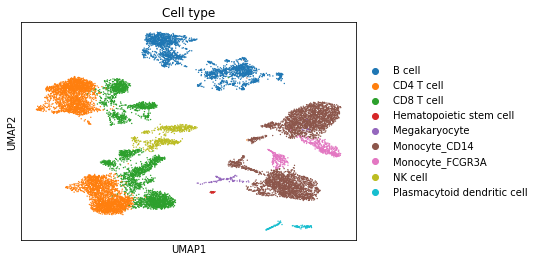

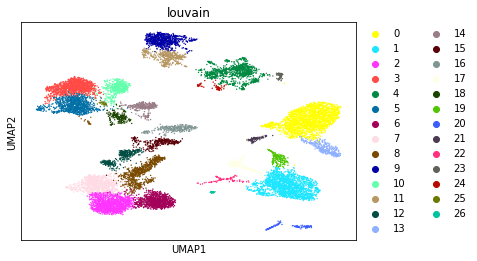

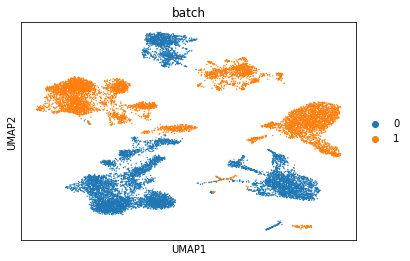

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## <span style="color:red">AEDWIP TODO</span>

- after louvain split into  sets 3prime and 5prime
- create two plots batch vs cell type

### 3 and 5 prime cells clusters are different

In [6]:
prime3Rows = anndata.obs['Method'] == '10X_3prime'
prime5Rows = anndata.obs['Method'] == '10X_5prime'
print("prime3Rows.sum(): {}".format(prime3Rows.sum()))
print("prime5Rows.shape: {}".format(prime5Rows.sum()))

# save output created by running louvain on combined data set
louvainClustersSave =  anndata.obs.loc[:,['louvain']]
cellTypeSave = anndata.obs.loc[:, ['Cell type']]
batchSave = anndata.obs.loc[:, ['batch']]

# select the 3prime and 5prime data we want to plot
prime3Cluster = louvainClustersSave.loc[prime3Rows,:]
prime5Cluster = louvainClustersSave.loc[prime5Rows,:]

prime3CellType = anndata.obs.loc[prime3Rows,['Cell type']]
prime5CellType = anndata.obs.loc[prime5Rows,['Cell type']]

prime3Batch = anndata.obs.loc[prime3Rows,['batch']]
prime5Batch = anndata.obs.loc[prime5Rows,['batch']]

prime3Rows.sum(): 8098
prime5Rows.shape: 7378


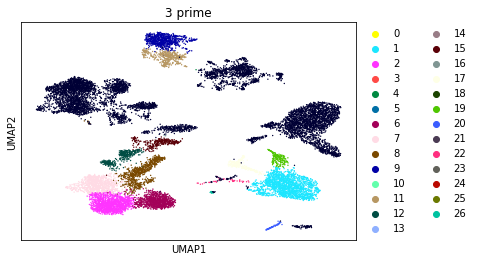

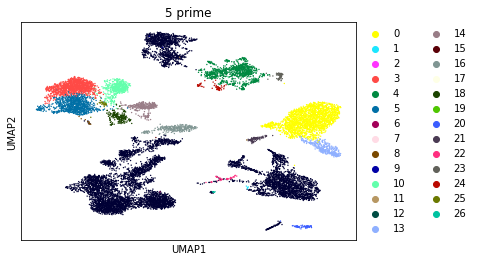

In [7]:
# plot 3 prime
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime3Cluster
scanpy.pl.umap(anndata, color=["louvain"], title="3 prime")

# plot 5 prime
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime5Cluster
scanpy.pl.umap(anndata, color=['louvain'], title="5 prime")

### cell typed differ between batchs

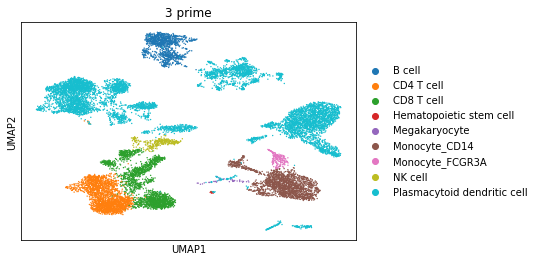

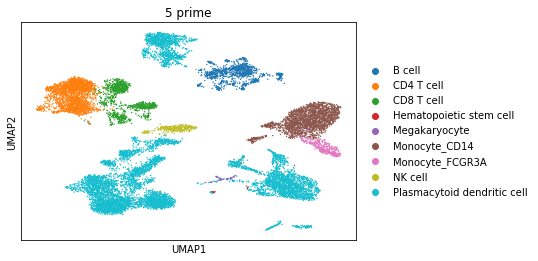

In [8]:
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime3Cluster
anndata.obs['Cell type'] = None # remove artifacts
anndata.obs.loc[:,['Cell type']] = prime3CellType
scanpy.pl.umap(anndata, color=['Cell type'], title="3 prime")

anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime5Cluster
anndata.obs['Cell type'] = None # remove artifacts
anndata.obs.loc[:,['Cell type']] = prime5CellType
scanpy.pl.umap(anndata, color=['Cell type'], title="5 prime")

## <span style="color:red">Bug?</span>
looks like 3 prime has some 5 prime in it. test that 'batch' and 'method' cols agree

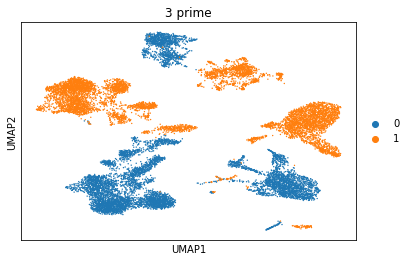

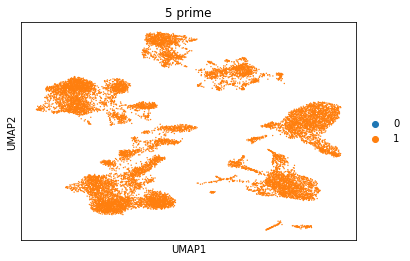

In [9]:
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime3Cluster
anndata.obs['batch'] = None # remove artifacts
anndata.obs.loc[:,['batch']] = prime3Batch
scanpy.pl.umap(anndata, color=["batch"], title="3 prime")

anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = prime5Cluster
anndata.obs['batch'] = None # remove artifacts
anndata.obs.loc[:,['batch']] = prime5Batch
scanpy.pl.umap(anndata, color=['batch'], title="5 prime")

In [10]:
# restore original calculated cluster for combined data set
anndata.obs['louvain'] = None # make sure there are not artifacts
anndata.obs.loc[:,['louvain']] = louvainClustersSave

anndata.obs['Cell type'] = None # make sure there are not artifacts
anndata.obs.loc[:,['Cell type']] = cellTypeSave

anndata.obs['batch'] = None # make sure there are not artifacts
anndata.obs.loc[:,['batch']] = batchSave

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [11]:
#anndata.obs['louvain'].head(3)

In [12]:
#anndata.obs.loc[:,['louvain', 'Cell type']].head()

In [13]:
df = anndata.obs.loc[:,['louvain', 'Cell type']]
df.head()

,louvain,Cell type
index,,
data_3p-AAACCTGAGCATCATC-0,9,B cell
data_3p-AAACCTGAGCTAGTGG-0,7,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,2,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,1,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,1,Monocyte_CD14


In [14]:
grouped = df.groupby(['louvain', 'Cell type'])
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                    17
         Monocyte_CD14                  2069
         Monocyte_FCGR3A                  21
1        Monocyte_CD14                  1708
         Monocyte_FCGR3A                   8
2        CD4 T cell                     1393
         CD8 T cell                       13
3        CD4 T cell                     1186
         CD8 T cell                       13
4        B cell                         1034
         Monocyte_CD14                     2
5        CD4 T cell                      979
         CD8 T cell                        5
6        CD4 T cell                        6
         CD8 T cell                      936
7        CD4 T cell                      851
         CD8 T cell                       21
8        CD4 T cell                       27
         CD8 T cell                      745
9        B cell                          763
10       CD4 T cel

In [18]:
def createCountsDict(pandasGroupedData, keys):
    '''
    assumes the data has been grouped by cluster id and cell type. 
    
    return:
        cellCountsByClusterId: 
            a dictionary of form d['clusterId']['cellType'] == count
            
        cellTypesInClusters:
            a dictionary of form d['clusterId']{'cell type1', 'cell type2'}
    
    arguments:
        pandasGroupedData:
            example : df.groupby(['louvain', 'Cell type'])['louvain'].count()
            
        keys:
            example: grouped.groups.keys()
    '''
    cellCountsByClusterId = {}
    cellTypesInClusters = {}
    for tup in keys:
        clusterId,cellType = tup
        if cellType not in cellCountsByClusterId :
            cellCountsByClusterId[cellType] = {}

        cellCountsByClusterId[cellType][clusterId] = pandasGroupedData[tup]
        
        if clusterId not in cellTypesInClusters:
            cellTypesInClusters[clusterId]= set()
        
        cellTypesInClusters[clusterId].add(cellType)
        
    return cellCountsByClusterId, cellTypesInClusters
        

d1, d2 = createCountsDict(pandasGroupedData=grouped['louvain'].count(), 
                                         keys=grouped.groups.keys())
cellCountsByClusterId = d1
cellTypesInClusters = d2

#print(cellCountsByClusterId)
#print(cellTypesInClusters)

{'0': {'B cell', 'Monocyte_CD14', 'Monocyte_FCGR3A', 'Megakaryocyte'}, '1': {'Monocyte_CD14', 'Monocyte_FCGR3A'}, '10': {'CD4 T cell', 'CD8 T cell'}, '11': {'B cell'}, '12': {'CD8 T cell'}, '13': {'Monocyte_CD14', 'Monocyte_FCGR3A'}, '14': {'CD8 T cell'}, '15': {'CD4 T cell', 'CD8 T cell', 'NK cell'}, '16': {'NK cell'}, '17': {'Monocyte_CD14'}, '18': {'CD8 T cell'}, '19': {'Monocyte_FCGR3A'}, '2': {'CD4 T cell', 'CD8 T cell'}, '20': {'Plasmacytoid dendritic cell'}, '21': {'Monocyte_CD14'}, '22': {'Megakaryocyte'}, '23': {'B cell'}, '24': {'B cell'}, '25': {'CD4 T cell', 'CD8 T cell'}, '26': {'CD8 T cell', 'Hematopoietic stem cell', 'Monocyte_CD14'}, '3': {'CD4 T cell', 'CD8 T cell'}, '4': {'B cell', 'Monocyte_CD14'}, '5': {'CD4 T cell', 'CD8 T cell'}, '6': {'CD4 T cell', 'CD8 T cell'}, '7': {'CD4 T cell', 'CD8 T cell'}, '8': {'CD4 T cell', 'CD8 T cell'}, '9': {'B cell'}}


## <span style="color:red">2.c AEDWIP TODO</span>
- [Hypergeometric_distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution)
- [Hypergeometric Tests
for Gene Lists](http://users.unimi.it/marray/2007/material/day4/Lecture7.pdf)

- Not sure what we are supposed to do?
- for each cluster we have a list of cell types and their counts
- we could run a Multivariate hypergeometric distribution
- what is the universe of genes we could have selected from?
    * E.G. cluster 1, 
```
        + 0        B cell                            1
                   Megakaryocyte                     5
                   Monocyte_CD14                  1910
                   Monocyte_FCGR3A                  19
```

In [ ]:
def cellCount(df, cellType):
    rows = (df.loc[:,['Cell type']] == cellType)
    n = rows.sum()
    # n is a pandas series
    return n.values[0]
   
nBCell = cellCount(df, 'B cell')
print("nBCell:{}".format(nBCell)) 

nMegakaryocyte = cellCount(df, 'Megakaryocyte')
print("nBCell:{}".format(nMegakaryocyte)) 

nMonocyte_CD14 = cellCount(df, 'Monocyte_CD14')
print("nMonocyte_CD14:{}".format(nMonocyte_CD14)) 

nMonocyte_FCGR3A = cellCount(df, 'Monocyte_FCGR3A')
print("nMonocyte_FCGR3A:{}".format(nMonocyte_FCGR3A)) 

N = nBCell + nMegakaryocyte + nMonocyte_CD14 + nMonocyte_FCGR3A
print("N:{}".format(N))

In [ ]:
# find the number of sucess we are intersted in 
clusterId = '0'
kBCells = cellCountsByClusterId['B cell'][clusterId]
kMegakaryocyteCells = cellCountsByClusterId['Megakaryocyte'][clusterId]
kMonocyte_CD14 = cellCountsByClusterId['Monocyte_CD14'][clusterId]
print(kMonocyte_CD14)
knMonocyte_FCGR3A =cellCountsByClusterId['Monocyte_FCGR3A'][clusterId]

In [ ]:
a = scipy.special.binom(nBCell,           kBCells)
b = scipy.special.binom(nMegakaryocyte,   kMegakaryocyteCells)
c = (scipy.special.binom(nMonocyte_CD14,   kMonocyte_CD14))
d = scipy.special.binom(nMonocyte_FCGR3A, knMonocyte_FCGR3A)

denominator = scipy.special.binom(N, kBCells + kBCells + kMonocyte_CD14 + knMonocyte_FCGR3A)

print(a, b, c, d,)
p = (a * b * c * d)/denominator
p

In [ ]:
print(nMonocyte_CD14)
print(kMonocyte_CD14)
# scipy.special.binom(nMonocyte_CD14, kMonocyte_CD14)

print(scipy.special.binom(10,3))
num = [i for i in range(10,3, -1)]
print(num)
print(np.prod(num))

dem = [j for j in range(1, 10 - 3)]
print(dem)
print(np.prod(dem))



In [ ]:
num = [i for i in range(nMonocyte_CD14, kMonocyte_CD14, -1)]
dem = [j for j in range(1, nMonocyte_CD14 - kMonocyte_CD14)]

np.prod(num) / np.prod(dem)


In [ ]:
print(num[0:8])
print(num[-8:])
print(dem[0:8])
print(dem[-8:])

## 2.d. [5 pts] 
Turn in a list of top 5 pathways for each cluster in each dataset. You should
use the gene expression signature of each cluster to find an associated pathway. A gene
signature for a cluster represents the gene expression levels for a characteristic cell that is a
member of the cluster. Use the centroid 𝞵 i of the i th cluster as the signature. Compute the
centroids for each cluster in each dataset. You will next derive a gene-signature based
annotation for each cluster using these centroids. Use a list of Gene Ontology Biological
Process categories (provided in the Resources section at the top of this homework) and your
signatures to perform an all-against-all Gene Set Enrichment Analysis (GSEA). Turn in a table
that lists the top 5 pathways for each cluster

hello world

1. create a data frame we can use to select the cells in a given cluster
    a. we need the index value we can use to to get the cell's expression
    values from the numpy array anndata.obsm['X_pca'].shape

In [ ]:
numCells = anndata.obs['louvain'].size
numCells

numpyArrayIdx = [i for i in range(numCells)]
d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
louvainDF = pd.DataFrame(data=d)
louvainDF.head()

In [ ]:
cluster9Cells = louvainDF['louvain'] == '9'
cluster9Cells.head()

In [ ]:
louvainDF.loc[cluster9Cells, :].count()

In [ ]:
louvainDF.loc[cluster9Cells, :].head()

In [ ]:
louvainDF.loc[cluster9Cells, ['npIdx']].head()

In [ ]:
def getCellsIdxForCluster(anndata, clusterId):
    '''
    returns a list of indices that can be use to select the cells in 
    the cluster. the indices are int values that correspond to the
    rows in the numpy array anndata.obsm['X_pca']
    
    assumes clustering algorithym was run and results stored in
    anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    numCells = anndata.obs['louvain'].size

    numpyArrayIdx = [i for i in range(numCells)]
    d = {'louvain':anndata.obs['louvain'], 'npIdx':numpyArrayIdx }
    louvainDF = pd.DataFrame(data=d)
    
    clusterCells = louvainDF['louvain'] == clusterId
    ret = louvainDF.loc[cluster9Cells, ['npIdx']]
    return ret.values.flatten()
    
def testGetCellsIdxForCluster(anndata):
    ret = getCellsIdxForCluster(anndata,clusterId=9)
    print("AEDWIP len(ret):{}".format(len(ret)))
    # print("AEDWIP type(ret):{}".format(type(ret)))
    # print ("AEDWIP ret:\n{}".format(ret))
    # count varies slightly from kernal restart to kernal restart
    # sending random.seed() or using , random_state=42 argument to
    # scanpy.louvain() did not resolve this issue
    # assert 747 == len(ret)
    
testGetCellsIdxForCluster(anndata)

In [ ]:
# cellIndices = getCellsIdxForCluster(anndata,clusterId=9)
# print(type(cellIndices))
# print(cellIndices.shape)
# print(type(anndata.obsm['X_pca']))
# print(anndata.obsm['X_pca'].shape)
# print(anndata.obsm['X_pca'][cellIndices].shape)
# anndata.obsm['X_pca'][cellIndices]

In [ ]:
def getGeneExpressionSignatureForCluster(anndata, clusterId):
    '''
    returns the centroid for cluster
    
    assumes:
        1) gene expression values stored in anndata.X
        
        2) clustering algorithym was run and results stored in
            anndata.obs['louvain']
    
    arguments:
        anndata
        clusterId: a string
    '''
    cellIndices = getCellsIdxForCluster(anndata ,clusterId)
    # pathways are in gene space not pca(50) space
    # anndata.obsm is a pandas data frame
    # data = anndata.obsm['X_pca'][cellIndices]
    # anndata.X is numpy array
    data = anndata.X[cellIndices, :]

    byColumns = 0
    return np.mean(data, axis=byColumns)

def testGetGeneExpressionSignatureForCluster(anndata):
    ret = getGeneExpressionSignatureForCluster(anndata, clusterId='9')
    # PCA 50
    #expFirst = np.array([-5.547451, 13.029236, -0.9483415, 
    #                    -5.8531246, -2.0250516])
    #expLast = np.array([-0.05719902, -0.16065401, 0.14730875, 
    #                    0.00936914, -0.06920523])
    
    # anndata.XC
    print("ret[0:5]:\n{}".format(ret[0:5]))
    print("ret[-5:]:\n{}".format(ret[-5:]))

    # count varies slightly from kernal restart to kernal restart
    # sending random.seed() or using , random_state=42 argument to
    # scanpy.louvain() did not resolve this issue
#     np.testing.assert_array_almost_equal(expFirst, ret[0:5])
#     np.testing.assert_array_almost_equal(expLast, ret[-5:])
    
testGetGeneExpressionSignatureForCluster(anndata)

In [ ]:
# print( pd.unique(louvainDF.loc[:, ['louvain']]) )
print( pd.unique(louvainDF['louvain']) )
clusterSigs = {}
for clusterId in pd.unique(louvainDF['louvain']) :
    sig = getGeneExpressionSignatureForCluster(anndata, clusterId)
    clusterSigs[clusterId] = sig

#clusterSigs['3']

In [ ]:
rnkDf = pd.DataFrame(data={'gene':anndata.var['GeneName-0'],
                           'score':clusterSigs['0']})
pre_res = gp.prerank(rnk=rnkDf, gene_sets='GO_Biological_Process_2018',
                     processes=4,
                     permutation_num=100, # reduce number to speed up test
                     outdir='./test/prerank_report_kegg',format='png')
                     

In [ ]:
type(pre_res)
pre_res.figsize
#pre_res.results


In [ ]:
goDF1 = pd.read_csv("./test/prerank_report_kegg/gseapy.prerank.gene_sets.report.csv")
print(type(goDF1))
goDF1.head()
sort on nes, highier is best

In [ ]:
# goDF1.sort('pval')
# goDF1.sort('pval')
goDF1.sort_values('pval')